In [0]:
import keras.backend as K
import multiprocessing
import tensorflow as tf
import warnings

from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import preprocess_input

from scipy.optimize import minimize

from skimage import img_as_float, img_as_ubyte
from skimage.io import imread, imsave
from skimage.transform import pyramid_gaussian, rescale

Using TensorFlow backend.


In [0]:
import scipy
from keras.preprocessing import image

In [0]:
from keras.applications.vgg19 import preprocess_input

In [0]:
!wget https://www.dropbox.com/s/h7b1hn6ck4xmeuf/cat.png

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
base_image_path = '/content/cat.png'
style_reference_image_path = '/content/style image.png'

iterations = 1

img_nrows = 224; img_ncols = 224

In [0]:
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img[:, :, :, 0] -= 103.939
    img[:, :, :, 1] -= 116.779
    img[:, :, :, 2] -= 123.68
    img = img[:, :, :, ::-1]/255
    return img

In [0]:
def deprocess_image(x):
  x = x[:,:,:,::-1]*255
  x[:, :, :, 0] += 103.939
  x[:, :, :, 1] += 116.779
  x[:, :, :, 2] += 123.68
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
from keras.applications import inception_v3
from keras import backend as K
model = VGG19(include_top=False, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 3s 0us/step


In [0]:
import numpy as np
img = preprocess_image('/content/cat.png')

In [0]:
img.shape

(1, 224, 224, 3)

In [0]:
layer_contributions = {
    'block2_pool':0.3,
'block5_pool': 1.5
}

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)
for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]
  activation = layer_dict[layer_name].output
  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  loss += coeff * K.sum(K.square(activation)) / scaling
  print(loss)

Tensor("add:0", shape=(), dtype=float32)
Tensor("add_1:0", shape=(), dtype=float32)


In [0]:
dream = model.input
grads = K.gradients(loss, dream)[0]
print(dream, grads)

Tensor("input_1:0", shape=(?, ?, ?, 3), dtype=float32) Tensor("gradients/block1_conv1/convolution_grad/Conv2DBackpropInput:0", shape=(?, ?, ?, 3), dtype=float32)


In [0]:
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

In [0]:
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

In [0]:
def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_value = outs[0]
  grad_values = outs[1]
  return loss_value, grad_values

In [0]:
def gradient_ascent(x, iterations, step, max_loss=None):
  for i in range(iterations):
    loss_value, grad_values = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
      break
    
    print('...Loss value at', i, ':', loss_value)
    x += step * grad_values
  return x

...Loss value at 0 : 4.0186324


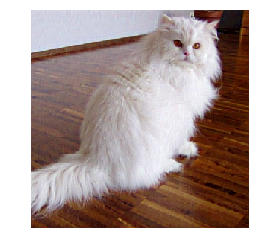

...Loss value at 1 : 4.849667


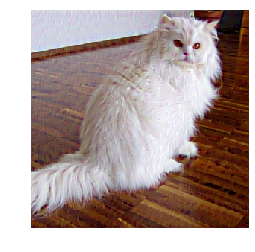

...Loss value at 2 : 5.8870955


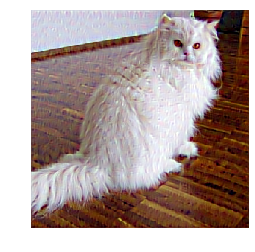

...Loss value at 3 : 7.0834827


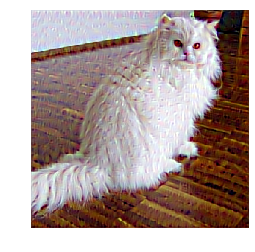

...Loss value at 4 : 8.417871


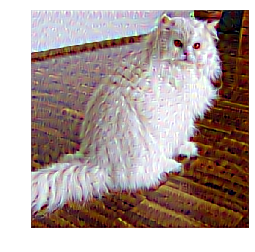

...Loss value at 5 : 9.80095


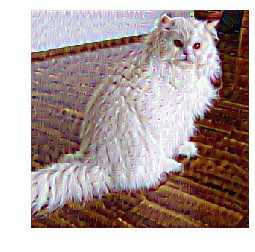

...Loss value at 6 : 11.187095


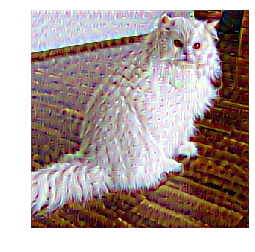

...Loss value at 7 : 12.784455


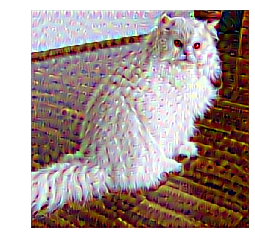

...Loss value at 8 : 14.428412


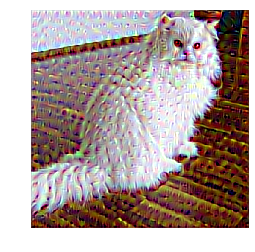

...Loss value at 9 : 16.12743


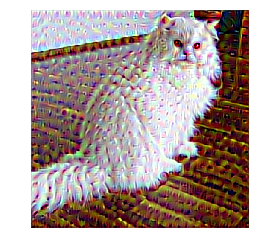

...Loss value at 10 : 17.824446


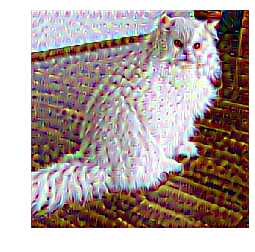

...Loss value at 11 : 19.684595


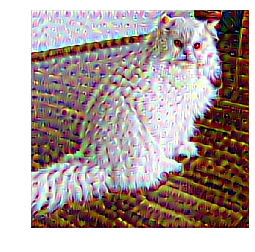

21.560284


In [0]:
for i in range(100):
  #print(loss)
  step=0.01
  max_loss=20
  loss_value, grad_values = eval_loss_and_grads(img)
  if max_loss is not None and loss_value > max_loss:
    print(loss_value)
    break
  print('...Loss value at', i, ':', loss_value)
  img += step * grad_values
  img2 = deprocess_image(img.copy())
  plt.imshow(img2[0,:,:,:])
  plt.axis('off')
  plt.show()
  